In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras import layers, models
from keras.applications import InceptionV3

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

from torchvision import models

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.WARNING)


In [5]:
base_path = "dataset"
dogs_directory = "dog"
cats_directory = "cat"

In [7]:
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    for label, category in enumerate([dogs_directory , cats_directory]):
        category_path = os.path.join(base_path, category)
        for filename in os.listdir(category_path)[:3000]:
            if filename.endswith(".jpg"):
                image_path = os.path.join(category_path, filename)
                image = cv2.imread(image_path)

                if image is not None and not image.size:
                    print(f"Invalid image size: {image_path}")
                    continue

                image = cv2.resize(image, (128, 128))  
                images.append(image)
                labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=2) 

    return images, labels

images, labels = load_and_preprocess_data(base_path)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
def plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy ):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax1 = axes[0]
    ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    ax1.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')

    ax1.set_title(f'Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2 = axes[1]
    ax2.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    ax2.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')

    ax2.set_title(f'Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()


    plt.tight_layout()
    plt.show()

In [11]:
y_train_indices = torch.argmax(torch.from_numpy(y_train), dim=1)
y_test_indices = torch.argmax(torch.from_numpy(y_test), dim=1)

X_train, y_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float(), y_train_indices.long()
X_test, y_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).float(), y_test_indices.long()

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [12]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)


In [13]:
def execute_model(  pytorch_model , epoch=5 ):

    optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler
    criterion = nn.CrossEntropyLoss()

    num_epochs = epoch

    train_loss = []
    train_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        pytorch_model.train()
        epoch_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()


            nn.utils.clip_grad_norm_(pytorch_model.parameters(), 1.0)

            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        average_epoch_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / len(train_loader.dataset)

        pytorch_model.eval()
        val_loss = 0.0
        val_correct_predictions = 0

        test = []
        predicted = []

        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_outputs = pytorch_model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)

                test.append(val_labels)
                predicted.append(val_predicted)

                val_correct_predictions += (val_predicted == val_labels).sum().item()

        average_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct_predictions / len(test_loader.dataset)

        train_loss.append(float("{:.4f}".format(average_epoch_loss)))
        train_accuracy.append(float("{:.2f}".format(accuracy * 100)))
        validation_loss.append(float("{:.4f}".format(average_val_loss)))
        validation_accuracy.append(float("{:.2f}".format(val_accuracy * 100)))

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {average_epoch_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%, "
              f"Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_loss, train_accuracy, validation_loss, validation_accuracy, pytorch_model , test , predicted

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
train_loss, train_accuracy, validation_loss, validation_accuracy, pytorch_model , test , predicted = execute_model( model.to(device) )

Epoch 1/5, Train Loss: 0.3641, Train Accuracy: 85.16%, Val Loss: 0.3464, Val Accuracy: 85.25%
Epoch 2/5, Train Loss: 0.2067, Train Accuracy: 91.64%, Val Loss: 0.3602, Val Accuracy: 85.25%
Epoch 3/5, Train Loss: 0.1601, Train Accuracy: 93.87%, Val Loss: 0.2722, Val Accuracy: 91.25%
Epoch 4/5, Train Loss: 0.1094, Train Accuracy: 96.12%, Val Loss: 0.2275, Val Accuracy: 90.50%
Epoch 5/5, Train Loss: 0.0769, Train Accuracy: 96.98%, Val Loss: 0.3333, Val Accuracy: 90.17%


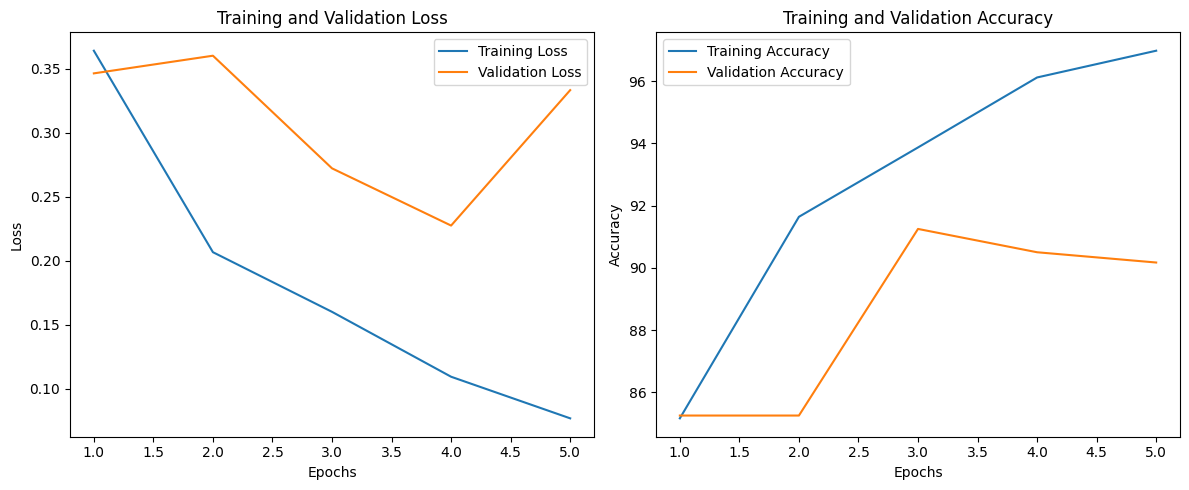

In [17]:
plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy )

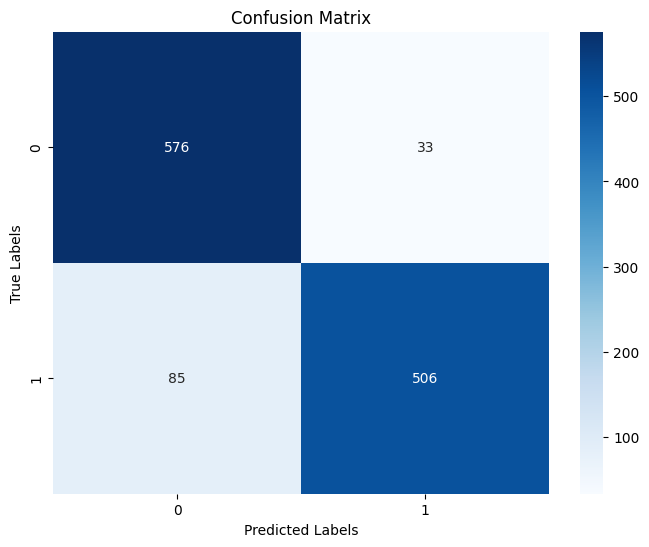

In [20]:

cm = confusion_matrix(np.concatenate([t.numpy() for t in test]),  np.concatenate([t.numpy() for t in predicted]))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()